In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


C:\Users\felip\AppData\Local\Temp\ipykernel_12516\848947246.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load('segmented_files/segmento_49.mpeg')


117.45383522727273


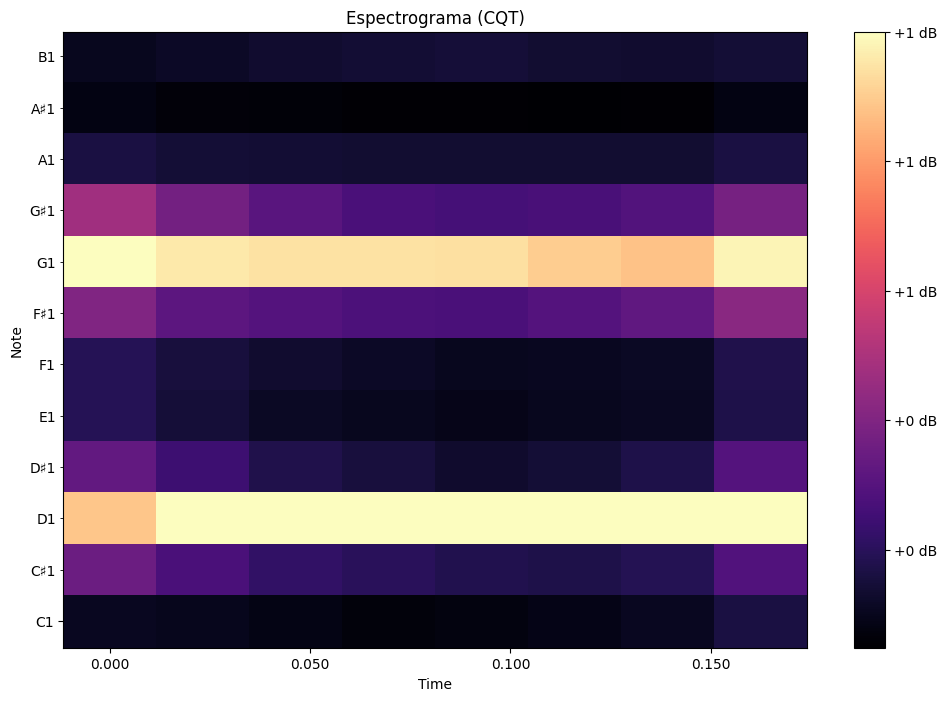

In [53]:
y, sr = librosa.load('segmented_files/segmento_49.mpeg')

'''sample rate, que se refere à taxa de amostragem do áudio. 
A taxa de amostragem é o número de amostras de áudio coletadas 
por segundo quando o áudio é convertido de uma forma analógica 
para uma forma digital'''

# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 512 # 512 é uma potencia de 2 e facilita a transformada de fourier

y_harmonic, y_percussive = librosa.effects.hpss(y)

#Identificando o andamento
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
print(tempo)

# Compute MFCC features from the raw signal
# MFCC é uma tabela da distribuições das frequencias pelo tempo
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)


n_frames = mfcc.shape[1]  # Assumindo que mfcc.shape[0] é o número de coeficientes
width = n_frames if n_frames % 2 else n_frames - 1  # A largura deve ser um número ímpar

# the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc, width = width)

# Stack and synchronize between beat events
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),
                                    beat_frames)

# Compute lista features from the harmonic signal
# Transforma cada faixa de frequencia em notas musicais
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)
# Aggregate lista features between beat events
# We'll use the median value of each feature between beat frames
beat_lista = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

# stack all beat-synchronous features together
beat_features = np.vstack([beat_lista, beat_mfcc_delta])

#Aplicando a transformada de fourier no segmento harmonico
D = np.abs(librosa.stft(y_harmonic))

# transformando a amplitude do sinal em decibeis
DB = librosa.amplitude_to_db(D, ref=np.max)

# Plot o espectrograma com o lista_cqt
plt.figure(figsize=(12, 8))
librosa.display.specshow(chromagram, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma (CQT)')
plt.show()


O tempo deveria ser 70, mas faz sentido que tenha identificado dobrado.

# Features:

# Espectrograma
Em HZ

Em notas musicais

In [54]:
chromagram

array([[0.10609616, 0.09721278, 0.08343394, 0.06872447, 0.07530171,
        0.08667329, 0.10630964, 0.16159905],
       [0.35320762, 0.27424002, 0.21868406, 0.20083307, 0.18093015,
        0.17471012, 0.18976307, 0.28763646],
       [0.8882016 , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.33095086, 0.24412224, 0.17503348, 0.15376486, 0.12861715,
        0.14408064, 0.17413339, 0.29632416],
       [0.19117068, 0.14674275, 0.11404386, 0.1035409 , 0.09306263,
        0.10421166, 0.10974026, 0.17423835],
       [0.19110125, 0.15553986, 0.13390806, 0.1168545 , 0.10264987,
        0.10559229, 0.11526496, 0.17847246],
       [0.40021956, 0.31566787, 0.2950424 , 0.27572417, 0.27202222,
        0.29650217, 0.32675964, 0.42211005],
       [1.        , 0.9587811 , 0.94274855, 0.94064486, 0.94045526,
        0.90321374, 0.8796898 , 0.9790925 ],
       [0.4757161 , 0.36941612, 0.30675918, 0.27441728, 0.26357192,
        0.26808625, 0.293661

In [55]:
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr, n_octaves=4, bins_per_octave = 12)
chromagram.shape

(12, 8)

acordes estão mudando a cada 2.5 segundos

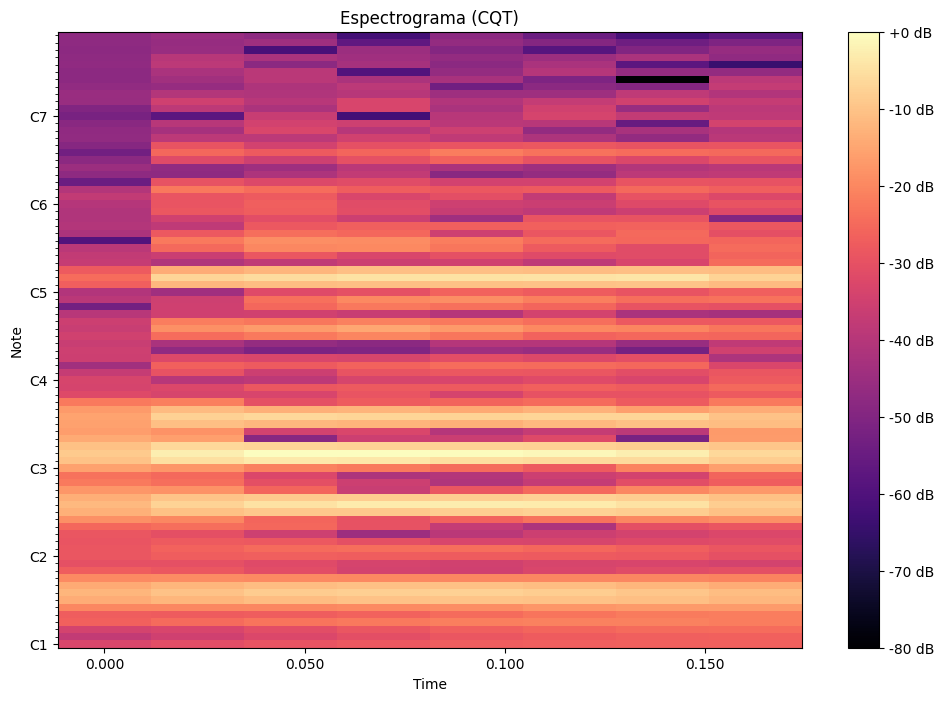

In [56]:
# Calcule o CQT (Constant-Q transform)
C = librosa.amplitude_to_db(np.abs(librosa.cqt(y_harmonic, sr=sr)), ref=np.max)

# Plot o espectrograma com o cqt
plt.figure(figsize=(12, 8))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma (CQT)')
plt.show()

In [57]:
# Calcule o CQT (Constant-Q transform)
C = librosa.amplitude_to_db(np.abs(librosa.cqt(y_harmonic, sr=sr)), ref=np.max)

In [58]:
C.shape

(84, 8)

In [59]:
C2 = C[12:-12]

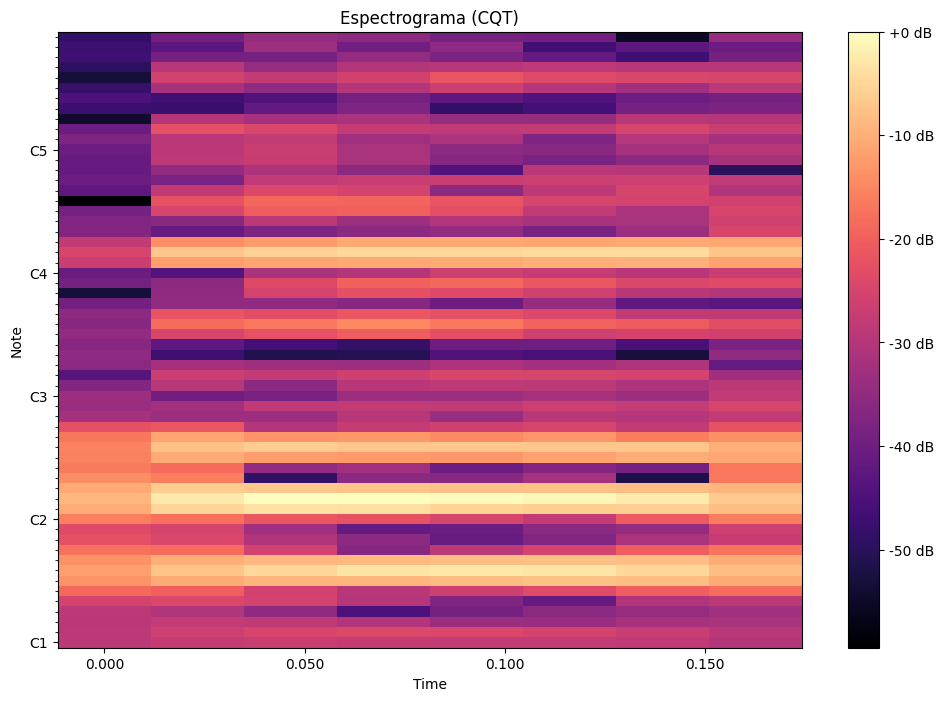

In [60]:
# Plot o espectrograma com o cqt
plt.figure(figsize=(12, 8))
librosa.display.specshow(C2, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma (CQT)')
plt.show()

In [61]:
C2.shape

(60, 8)

In [62]:
def identifica_picos(lista):

    n1, n2, n3 = 0, 1, 2
    picos_notas = []

    # verifica de 3 em 3, procurando picos
    while n3 < len(lista):

        if lista[n1] < lista[n2] > lista[n3]:
            picos_notas.append([n2, lista[n2]])

        n1, n2, n3 = n1+1, n2+1, n3+1

    # ordena com base no volume
    picos_notas = sorted(picos_notas, key=lambda x: x[1])

    return picos_notas


In [63]:
def identifica_fundamental(lista):

    #critério de seleção: linha com o maior valor
    linhas_somadas = np.sum(lista, axis=1)

    # argsort() retorna os índices que ordenariam um array.
    # [-2:] pega os dois últimos índices, que correspondem às maiores somas
    #i_maiores_somas = np.argsort(linhas_somadas)[-15:]
    
    picos_notas = identifica_picos(linhas_somadas)

    notas_musicais = {
    0: "Dó",
    1: "Dó#",
    2: "Ré",
    3: "Ré#",
    4: "Mi",
    5: "Fá",
    6: "Fá#",
    7: "Sol",
    8: "Sol#",
    9: "Lá",
    10: "Lá#",
    11: "Si"
    }

    for i in picos_notas:
        print(notas_musicais[i[0]%12])

    print(picos_notas)
    

In [64]:
identifica_fundamental(C2)

Ré
Si
Sol
Ré
Fá#
Dó#
Si
Sol
Sol
Ré
Sol
Ré
[[26, -232.61856], [23, -230.39847], [55, -227.38322], [50, -223.3039], [42, -211.61446], [1, -209.9035], [35, -206.38724], [31, -166.69336], [19, -68.073074], [38, -62.97242], [7, -46.53589], [14, -22.308784]]


pegar quem é a nota mais forte, pegar se a quinta também está entre as mais fortes e depois procurar a terça

C

In [65]:
C

array([[-33.01749   , -31.029255  , -29.470675  , -28.289297  ,
        -27.43807   , -26.890455  , -26.640316  , -26.692043  ],
       [-37.75488   , -35.19954   , -32.730965  , -30.653368  ,
        -29.004349  , -27.779583  , -26.977156  , -26.590921  ],
       [-34.331356  , -33.201946  , -31.097124  , -28.88699   ,
        -27.052507  , -25.70077   , -24.829666  , -24.42668   ],
       [-26.588629  , -24.815107  , -23.331635  , -22.221464  ,
        -21.507137  , -21.179298  , -21.219358  , -21.608328  ],
       [-27.271027  , -27.637129  , -27.475456  , -26.429594  ,
        -24.78787   , -23.230494  , -22.145031  , -21.57265   ],
       [-20.032377  , -20.019697  , -20.063807  , -19.677818  ,
        -18.806772  , -17.810465  , -17.067589  , -16.82633   ],
       [-13.928621  , -12.238823  , -11.028418  , -10.2773075 ,
         -9.991413  , -10.181625  , -10.863051  , -12.0701885 ],
       [-12.33066   , -10.184445  ,  -8.738058  ,  -7.954751  ,
         -7.8055096 ,  -8.28106  